In [3]:
# 📚 Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# ----- Cấu hình -----
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_PATH = '../../../Bai_4/data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
DARK_PATH = '../../../Bai_4/data_dark'
ALGORITHM_PATH = '../../../Bai_4/data_algorithm'
TRAIN_DARK_PATH = os.path.join(DARK_PATH, 'train')
TEST_DARK_PATH = os.path.join(DARK_PATH, 'test')
TRAIN_ALGORITHM_PATH = os.path.join(ALGORITHM_PATH, 'train')
TEST_ALGORITHM_PATH = os.path.join(ALGORITHM_PATH, 'test')

# Tạo các thư mục nếu chưa tồn tại
os.makedirs(TRAIN_DARK_PATH, exist_ok=True)
os.makedirs(TEST_DARK_PATH, exist_ok=True)
os.makedirs(TRAIN_ALGORITHM_PATH, exist_ok=True)
os.makedirs(TEST_ALGORITHM_PATH, exist_ok=True)

# ----- Hàm tạo ảnh tối -----
def create_dark_image(image, brightness_range=[0.1, 0.1]):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[..., 2] = hsv[..., 2] * np.random.uniform(brightness_range[0], brightness_range[1])
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# ----- Hàm tăng cường sáng -----
def adaptive_augmentation(image, T1=50, T2=100, gamma_low=0.5, gamma_mid=0.8):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mean_intensity = np.mean(gray)
    if mean_intensity < T1:
        image = gamma_correction(image, gamma_low)
    elif T1 <= mean_intensity < T2:
        image = gamma_correction(image, gamma_mid)
    else:
        image = contrast_stretching(image)
    return image

def gamma_correction(image, gamma):
    table = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def contrast_stretching(image):
    stretched = np.zeros_like(image)
    for c in range(3):
        min_val = np.min(image[:, :, c])
        max_val = np.max(image[:, :, c])
        stretched[:, :, c] = ((image[:, :, c] - min_val) * 255.0 / (max_val - min_val + 1e-6))
    return stretched.astype(np.uint8)

# ----- Hàm xử lý ảnh -----
def process_images_for_train_and_test(path, dark_path, algorithm_path):
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if not os.path.isdir(class_path):
            continue

        # Tạo thư mục cho ảnh tối và ảnh sau thuật toán
        dark_class_path = os.path.join(dark_path, class_name)
        algorithm_class_path = os.path.join(algorithm_path, class_name)
        
        os.makedirs(dark_class_path, exist_ok=True)
        os.makedirs(algorithm_class_path, exist_ok=True)

        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            input_file = os.path.join(class_path, file_name)
            
            # Đọc ảnh, resize và chuyển sang RGB
            img = cv2.imread(input_file)
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 1. Tạo ảnh tối và lưu
            dark_img = create_dark_image(img_rgb)
            dark_file_path = os.path.join(dark_class_path, file_name)
            cv2.imwrite(dark_file_path, cv2.cvtColor(dark_img, cv2.COLOR_RGB2BGR))

            # 2. Áp dụng thuật toán tăng cường sáng và lưu ảnh
            enhanced_img = adaptive_augmentation(dark_img)
            enhanced_file_path = os.path.join(algorithm_class_path, file_name)
            cv2.imwrite(enhanced_file_path, cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))

# Gọi hàm để xử lý ảnh trong tập train và test
process_images_for_train_and_test(TRAIN_PATH, TRAIN_DARK_PATH, TRAIN_ALGORITHM_PATH)
process_images_for_train_and_test(TEST_PATH, TEST_DARK_PATH, TEST_ALGORITHM_PATH)

Processing disgust: 100%|██████████| 111/111 [00:00<00:00, 541.60it/s]


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    '../../../Bai_4/data_algorithm/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '../../../Bai_4/data_algorithm/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '../../../Bai_4/data_algorithm/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Small

# Base model
base_model = MobileNetV3Small(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Functional API
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 163s 219ms/step - accuracy: 0.4018 - loss: 1.5459 - val_accuracy: 0.4712 - val_loss: 1.4118
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 164s 229ms/step - accuracy: 0.5559 - loss: 1.1918 - val_accuracy: 0.5309 - val_loss: 1.2898
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 163s 227ms/step - accuracy: 0.6061 - loss: 1.0786 - val_accuracy: 0.5781 - val_loss: 1.1375
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 161s 225ms/step - accuracy: 0.6465 - loss: 0.9624 - val_accuracy: 0.5631 - val_loss: 1.2016
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 181s 252ms/step - accuracy: 0.6856 - loss: 0.8687 - val_accuracy: 0.5938 - val_loss: 1.1755
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 163s 228ms/step - accuracy: 0.7172 - loss: 0.7767 - val_accuracy: 0.5959 - val_loss: 1.1677


7178/7178 ━━━━━━━━━━━━━━━━━━━━ 75s 10ms/step - accuracy: 0.5595 - loss: 1.2171
Test Accuracy: 58.74%
7178/7178 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step


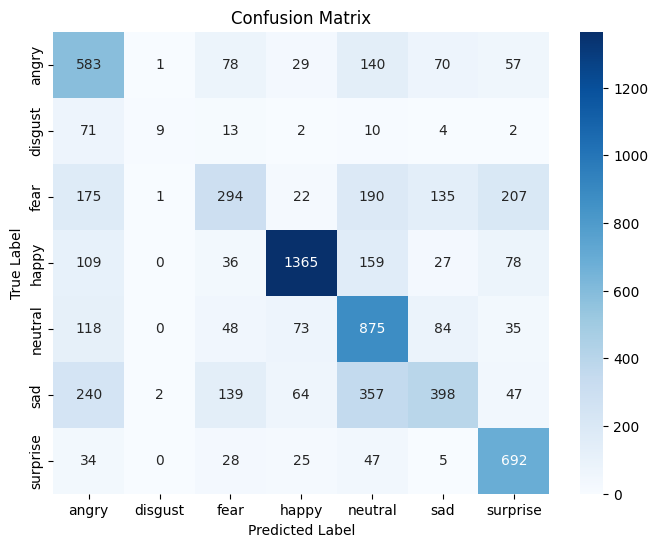

In [8]:
# Accuracy
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()